In [1]:
#from icepyx import query as ipd
import icepyx as ipx

import os
import shutil
from pathlib import Path
from pprint import pprint

import pandas as pd

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir("/glade/u/home/fsapienza/CloudMask")
from utils_atl06 import *

## Example No1

Retrieving ATL06 data from bounding box

In [4]:
spatial_extent = [ -50.71,  65.73, -45.32,  68.08]
date_range = ['2019-06-01','2019-06-05']

In [5]:
df = read_atl06(spatial_extent, 
                date_range, 
                time_start = "06:00:00", 
                time_end = "18:00:00",
                path = "./data/new_ATL06", 
                user = 'fsapienza', 
                email = 'fsapienza@berkeley.edu')

Available Granules: ['ATL06_20190601071608_09780303_003_01.h5', 'ATL06_20190601200102_09860305_003_01.h5', 'ATL06_20190605070748_10390303_003_01.h5']
You already donwload all the requiered files


In [6]:
df

,ground_track,time,segment_id,beam_strength,lat,lon,height,slope_dx,slope_dy,snr,...,c_flg_atm,msw,layer_flag,background,background_expected,q_flag_1,q_flag_2,q_flag_3,q_flag_4,q_flag_5
0,gt1l,2019-06-01 07:18:41.747013,371978,strong,66.862169,-45.326436,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
1,gt1l,2019-06-01 07:18:41.749913,371979,strong,66.862351,-45.326488,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
2,gt1l,2019-06-01 07:18:41.761213,371983,strong,66.863066,-45.326704,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
3,gt1l,2019-06-01 07:18:41.924563,372041,strong,66.873399,-45.329752,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
4,gt1l,2019-06-01 07:18:42.076715,372095,strong,66.883032,-45.332678,3.402823e+38,3.402823e+38,3.402823e+38,3.085928e-01,...,1,1,1,3.402823e+38,3.402823e+38,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173338,gt3r,2019-06-05 07:10:41.034480,378768,weak,68.079187,-46.321051,1.966368e+03,3.356695e-03,-2.106460e-03,4.448723e+01,...,0,0,0,2.410754e+06,8.382752e+05,0,0,0,0,0
173339,gt3r,2019-06-05 07:10:41.037286,378769,weak,68.079365,-46.321107,1.966487e+03,4.716873e-03,-2.153996e-03,4.556038e+01,...,0,0,0,2.380189e+06,8.382844e+05,0,0,0,0,0
173340,gt3r,2019-06-05 07:10:41.040093,378770,weak,68.079544,-46.321162,1.966602e+03,3.869057e-03,-2.432660e-03,4.550946e+01,...,0,0,0,2.372903e+06,8.382934e+05,0,0,0,0,0
173341,gt3r,2019-06-05 07:10:41.042906,378771,weak,68.079722,-46.321218,1.966702e+03,4.729509e-03,-2.593385e-03,4.706477e+01,...,0,0,0,2.446654e+06,8.383026e+05,0,0,0,0,0


In [7]:
df[df.q_flag == 1].shape

(5649, 32)

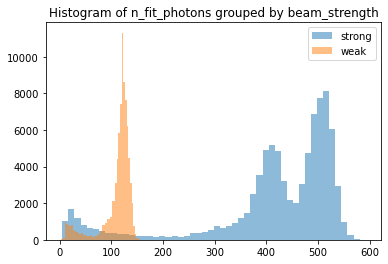

In [8]:
from utils import hist_df
hist_df(df[df.n_fit_photons < 10e3], 'n_fit_photons', 'beam_strength')

In [70]:
df['q_flag_1'] = df.apply(lambda row: 1 if (row.h_rb >= 1) else 0, axis = 1)
df['q_flag_2'] = df.apply(lambda row: 1 if (row.height_sigma >= 1) else 0, axis = 1)
df['q_flag_3'] = df.apply(lambda row: 1 if (row.snr_significance >= 0.02) else 0, axis = 1)
df['q_flag_4'] = df.apply(lambda row: 1 if (row.s_fg > 1) else 0, axis = 1)
df['q_flag_5'] = df.apply(lambda row: 1 if ( (row.beam_strength == 'strong' and row.n_fit_photons_ratio_w <= 4) or 
                                             (row.beam_strength == 'weak'   and row.n_fit_photons_ratio_w <= 1) ) else 0, axis = 1)

In [8]:
df.head()

,ground_track,time,segment_id,beam_strength,lat,lon,height,slope_dx,slope_dy,snr,...,c_flg_atm,msw,layer_flag,background,background_expected,q_flag_1,q_flag_2,q_flag_3,q_flag_4,q_flag_5
0,gt1l,2019-06-01 07:18:41.747013,371978,strong,66.862169,-45.326436,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
1,gt1l,2019-06-01 07:18:41.749913,371979,strong,66.862351,-45.326488,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
2,gt1l,2019-06-01 07:18:41.761213,371983,strong,66.863066,-45.326704,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
3,gt1l,2019-06-01 07:18:41.924563,372041,strong,66.873399,-45.329752,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
4,gt1l,2019-06-01 07:18:42.076715,372095,strong,66.883032,-45.332678,3.402823e+38,3.402823e+38,3.402823e+38,3.085928e-01,...,1,1,1,3.402823e+38,3.402823e+38,1,1,1,1,1


In [81]:
def p_a_cond_b (df, a, b):
    """
    Given a dataframes df, it computes the empirial conditionl probability
    """    
    
    assert all(np.unique(df[a]) == [0,1]), "Variable must be binary"
    assert all(np.unique(df[b]) == [0,1]), "Variable must be binary"
    
    p_b = df[df[b] == 1].shape[0]
    p_a_b = df[(df[a] == 1) & (df[b] == 1)].shape[0]
    
    return p_a_b / p_b

def conditional_heatplot(df, variables, plot = True):
    """
    Given a dataframes and a list of binary column names, it returns the matrix of all the conditional probabilities
    """
    
    res = np.zeros((len(variables), len(variables)))
    
    for i, x in enumerate(variables):
        for j, y in enumerate(variables):
            if i == j:
                res[i,j] = np.nan
                continue
            res[i,j] = p_a_cond_b(df, a = x, b = y)
            
    if plot:
        ax = sns.heatmap(res, annot=True, cmap = sns.color_palette("Blues"))        
    
    return res

In [82]:
all( np.unique(df['q_flag']) == [0,1] )

True

In [83]:
cond_matrix = conditional_heatplot(df, ['q_flag', 'q_flag_1', 'q_flag_2', 'q_flag_3', 'q_flag_4', 'q_flag_5'])

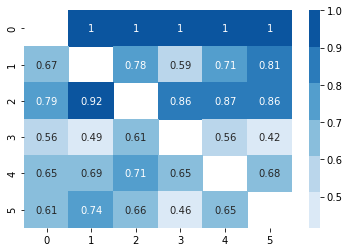

In [84]:
import seaborn as sns

ax = sns.heatmap(cond_matrix, annot=True, cmap = sns.color_palette("Blues"))

## Example No2 

Here we are going to retrieve granules included in one speficic granule basin in Greenland

<div>
<img src="https://icesat4.gsfc.nasa.gov/cryo_data/drainage_divides/Grn_Drainage_Systems.png" align="center" width="300"/>
</div>

#### Granule basin

In [4]:
from osgeo import osr

os.chdir("/glade/u/home/fsapienza/CloudMask/drainage_basis")

In [12]:
basin = '6.2'

zwally = pd.read_csv('GrnDrainageSystems_Ekholm.txt', sep='\s+', names=['basin', 'lat','long'])

LL = zip(zwally[zwally.basin == float(basin)].long, zwally[zwally.basin == float(basin)].lat)
LL = list(LL)

In [13]:
longitudes = [x[0] for x in LL]
# Since icepyx just accept longitudes in [-180, 180], we need to modify those longitudes in [180, 360]
longitudes = [x if ( (x >= 0) & (x <= 180)) else x - 360 for x in longitudes]

latitudes = [x[1] for x in LL]

In [14]:
LL = [(longitudes[i], latitudes[i]) for i in range(len(longitudes))]

In [15]:
spatial_extent = LL[::1000]
spatial_extent.append(spatial_extent[0])
date_range = ['2019-06-10','2019-06-30']

In [16]:
len(spatial_extent)

20

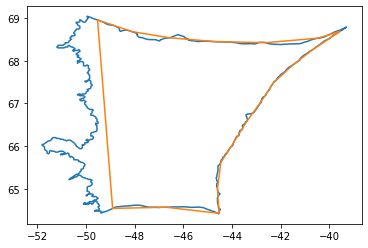

In [17]:
longitudes_icepyx = [x[0] for x in spatial_extent]
latitudes_icepyx = [x[1] for x in spatial_extent]

plt.plot(longitudes, latitudes)
plt.plot(longitudes_icepyx, latitudes_icepyx)

In [143]:
os.chdir("/glade/u/home/fsapienza/CloudMask")

In [150]:
df = read_atl06(spatial_extent, 
                date_range, 
                time_start = "00:00:00", 
                time_end = "23:59:59",
                path = "./data/new_ATL06", 
                user = 'fsapienza', 
                email = 'fsapienza@berkeley.edu')

Available Granules: ['ATL06_20190610063350_11150303_003_01.h5', 'ATL06_20190613065109_11610303_003_01.h5', 'ATL06_20190613193602_11690305_003_01.h5', 'ATL06_20190614062530_11760303_003_01.h5', 'ATL06_20190614191023_11840305_003_01.h5', 'ATL06_20190617064249_12220303_003_01.h5', 'ATL06_20190618061710_12370303_003_01.h5', 'ATL06_20190618190203_12450305_003_01.h5', 'ATL06_20190619183623_12600305_003_01.h5', 'ATL06_20190621063429_12830303_003_01.h5', 'ATL06_20190622060850_12980303_003_01.h5', 'ATL06_20190622185343_13060305_003_01.h5', 'ATL06_20190623182803_13210305_003_01.h5', 'ATL06_20190626060029_13590303_003_01.h5']
Total number of data order requests is  2  for  14  granules.
Data request  1  of  2  is submitting to NSIDC
order ID:  5000000913472
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order status is still  processing  at NSIDC. Please continue waiting..

In [151]:
longitude_df = df.lon.to_numpy()
latitude_df  = df.lat.to_numpy()

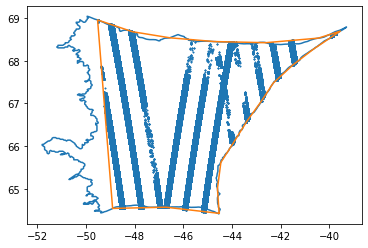

In [152]:
plt.plot(longitudes, latitudes)
plt.plot(longitudes_icepyx, latitudes_icepyx)
plt.scatter(longitude_df, latitude_df, 0.5)